In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Исследуем датасет со стоимостью активов



Прочитаем данные из csv файла, полученного на предыдущем этапе:



In [3]:
yahoo_finance_prices = pd.read_csv('yahoo_finance_dataset.csv')
yahoo_finance_prices['date'] = pd.to_datetime(yahoo_finance_prices['date']).dt.date
yahoo_finance_prices

,date,RUB=X,GC=F,CNY=X,CL=F,ES=F
0,2022-03-02,108.479500,1920.900024,6.3115,110.599998,4381.75
1,2022-03-03,102.714996,1934.400024,6.3196,107.669998,4359.25
2,2022-03-04,109.464996,1965.099976,6.3192,115.680000,4327.25
3,2022-03-07,108.845100,1993.900024,6.3167,119.400002,4198.50
4,2022-03-08,138.965103,2040.099976,6.3193,123.699997,4168.75
...,...,...,...,...,...,...
870,2025-02-26,86.595695,2916.800049,7.2476,68.620003,5970.75
871,2025-02-27,86.820770,2883.199951,7.2580,70.349998,5876.25
872,2025-02-28,87.698212,2836.800049,7.2853,69.760002,5963.25
873,2025-03-03,87.481758,2890.199951,7.2828,68.370003,5860.75


In [4]:
yahoo_finance_prices.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 875 entries, 0 to 874
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    875 non-null    object 
 1   RUB=X   784 non-null    float64
 2   GC=F    756 non-null    float64
 3   CNY=X   784 non-null    float64
 4   CL=F    756 non-null    float64
 5   ES=F    757 non-null    float64
dtypes: float64(5), object(1)
memory usage: 41.1+ KB


*   date - Дата измерения
*   RUB=X - Курс российского рубля к доллару США. Измеряется в долларах за рубль.
*   GC=F - Цена золота в долларах за унцию
*   CNY=X - Курс китайского юаня к доллару США. Измеряется в долларах за юань.
*   CL=F - Цена нефти (фьючерсы на нефть) в долларах за баррель.
*   ES=F - Индекс S&P 500 (фьючерсы) в долларах за контракт.


Проверим пропуски в данных

In [5]:
yahoo_finance_prices[yahoo_finance_prices.isna().any(axis=1)]

,date,RUB=X,GC=F,CNY=X,CL=F,ES=F
18,2022-03-27,100.839996,NaN,6.3652,NaN,NaN
23,2022-04-01,NaN,1919.099976,NaN,99.269997,4539.25
24,2022-04-03,84.214996,NaN,6.3621,NaN,NaN
29,2022-04-08,NaN,1941.599976,NaN,98.260002,4483.50
30,2022-04-10,85.089996,NaN,6.3640,NaN,NaN
...,...,...,...,...,...,...
782,2024-10-25,NaN,2740.899902,NaN,71.779999,5846.00
806,2024-11-28,113.141022,NaN,7.2462,NaN,NaN
825,2024-12-25,99.949051,NaN,7.2946,NaN,NaN
830,2025-01-01,NaN,NaN,NaN,NaN,NaN


Видим, что в столбце с иторическими данными довольно много дней, в которые не зафиксировано значение хотя бы по одному из активов. Проверим максимальный пробел, чтобы понять, мешает ли это решению нашей задачи.

In [7]:
def max_consecutive_nans(col):
    is_nan = col.isna()
    # если cumsum не увеличивается - идут пропуски. максимальное количество одинаковых значений - максимальное количество пропусков подряд
    cumsum = (~is_nan).cumsum()#массив со значениями от 1 которые растут с шагом 1, если в ячейке не NaN
    groups = is_nan.groupby(cumsum).cumsum()
    return groups.max()

max_consecutive_nans_per_col = yahoo_finance_prices.apply(max_consecutive_nans)
print('максимум пропусков подряд', max_consecutive_nans_per_col)
print('% пропусков:', yahoo_finance_prices.isna().sum() / len(yahoo_finance_prices) * 100)

максимум пропусков подряд date     0
RUB=X    1
GC=F     2
CNY=X    1
CL=F     2
ES=F     2
dtype: int64
% пропусков: date      0.000000
RUB=X    10.400000
GC=F     13.600000
CNY=X    10.400000
CL=F     13.600000
ES=F     13.485714
dtype: float64


Видим, что максимальный промежуток без данных по любому из активов составляем не более двух дней, а суммарное количество дней без значений составляет до 14% для каждой из колонок, поэтому можем заполнить пропуски, используя ffill.

In [ ]:
yahoo_finance_prices = yahoo_finance_prices.ffill()
# проверяем, что пропусков не осталось
yahoo_finance_prices.isna().any()

date     False
RUB=X    False
GC=F     False
CNY=X    False
CL=F     False
ES=F     False
dtype: bool

Провизуализируем данные:

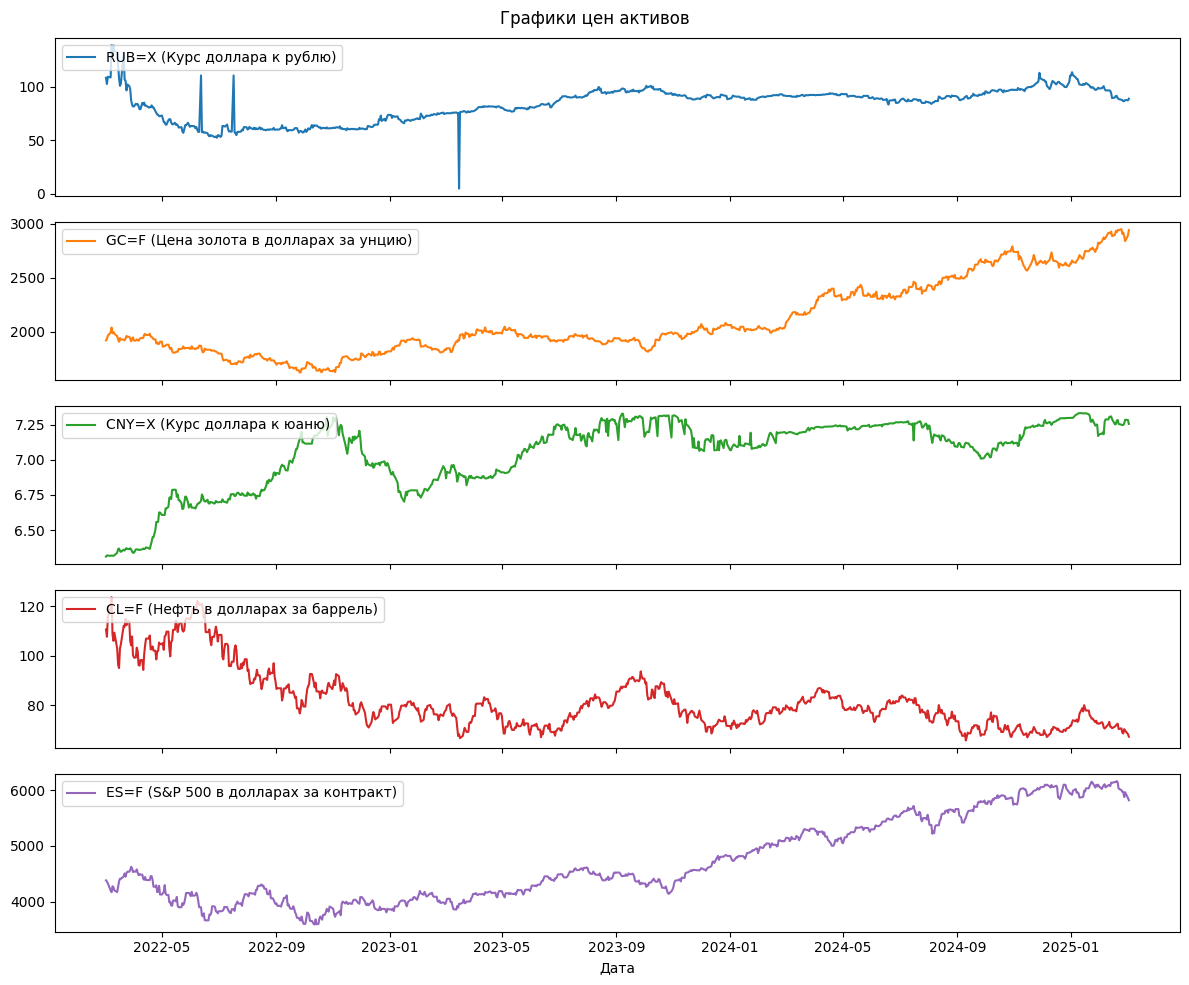

In [ ]:
fig, axs = plt.subplots(5, 1, figsize=(12, 10), sharex=True)

axs[0].plot(yahoo_finance_prices['date'], yahoo_finance_prices['RUB=X'], label="RUB=X (Курс доллара к рублю)", color='tab:blue')
axs[0].legend(loc='upper left')

axs[1].plot(yahoo_finance_prices['date'], yahoo_finance_prices['GC=F'], label="GC=F (Цена золота в долларах за унцию)", color='tab:orange')
axs[1].legend(loc='upper left')

axs[2].plot(yahoo_finance_prices['date'], yahoo_finance_prices['CNY=X'], label="CNY=X (Курс доллара к юаню)", color='tab:green')
axs[2].legend(loc='upper left')

axs[3].plot(yahoo_finance_prices['date'], yahoo_finance_prices['CL=F'], label="CL=F (Нефть в долларах за баррель)", color='tab:red')
axs[3].legend(loc='upper left')

axs[4].plot(yahoo_finance_prices['date'], yahoo_finance_prices['ES=F'], label="ES=F (S&P 500 в долларах за контракт)", color='tab:purple')
axs[4].legend(loc='upper left')

axs[4].set_xlabel('Дата')

fig.suptitle('Графики цен активов')
fig.tight_layout()

Видим, что в данных курса рубля присутствуют выбросы. Исследуем их:

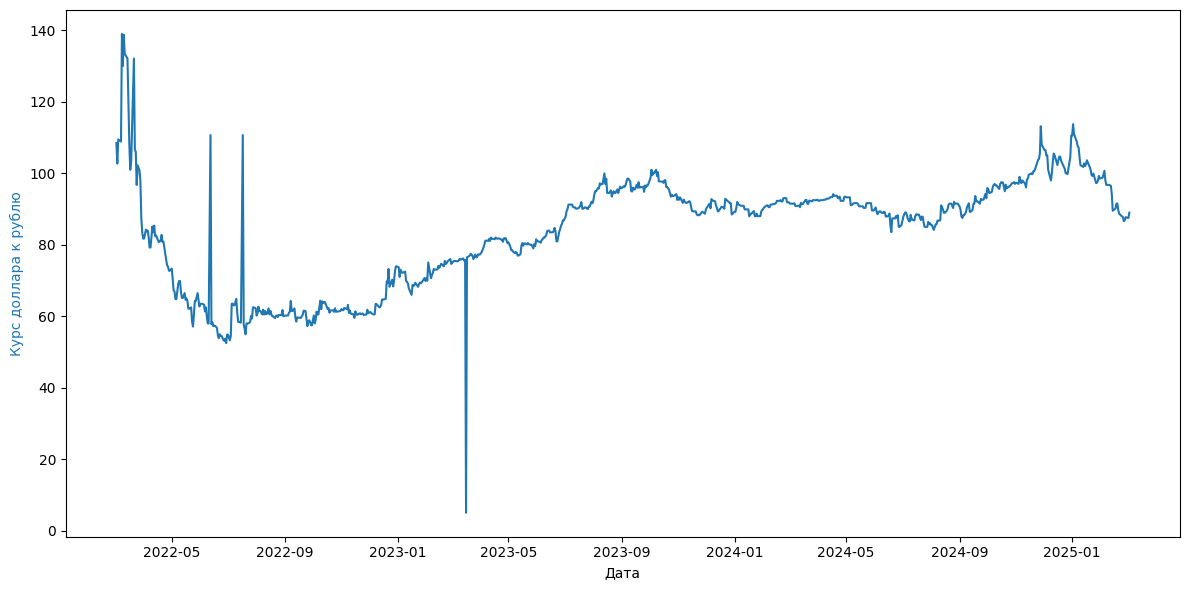

In [ ]:
fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.plot(yahoo_finance_prices['date'], yahoo_finance_prices['RUB=X'], color='tab:blue')
ax1.set_xlabel('Дата')
ax1.set_ylabel('Курс доллара к рублю', color='tab:blue')
fig.tight_layout()


In [ ]:
# посчитаем близость каждого значения к среднему соседей и выберем аномалии

# .shift(1) - сдвиг цены вперед на 1 значение - строке 2 будет присвоено значения строки 1
yahoo_finance_prices['rub_neighbour_diff'] = yahoo_finance_prices['RUB=X'] - (yahoo_finance_prices['RUB=X'].shift(1) + yahoo_finance_prices['RUB=X'].shift(-1)) / 2

# выбираем аномалии по разнице > 40 руб. за доллар
anomalies_mask = yahoo_finance_prices['rub_neighbour_diff'].abs() > 40
yahoo_finance_prices[anomalies_mask]

,date,RUB=X,GC=F,CNY=X,CL=F,ES=F,rub_neighbour_diff
83,2022-06-12,110.674103,1871.500000,6.7079,120.669998,3899.0,52.834103
113,2022-07-17,110.674103,1702.400024,6.7565,97.589996,3865.0,52.696602
301,2023-03-16,5.000000,1919.000000,6.9059,68.349998,3960.5,-71.089996


Видим, что выбросов три, и они вызваны некорректными значениями - 2022-03-02, 2022-06-13 и 2022-07-18. Заменим эти значения на предшествующие.

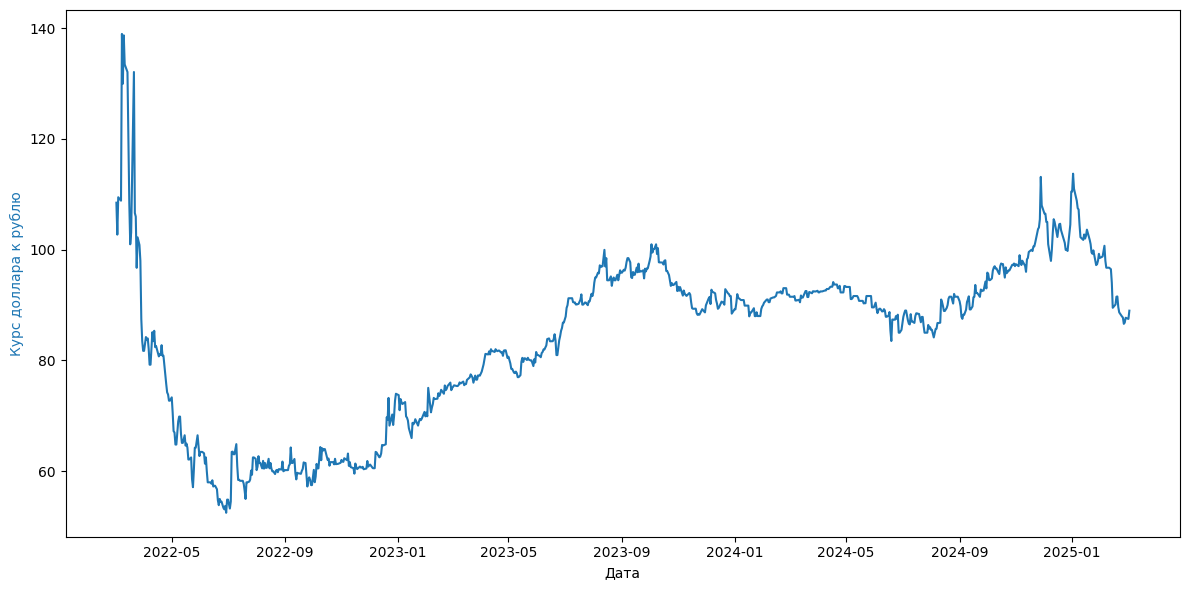

In [ ]:
anomalies_index = yahoo_finance_prices[anomalies_mask].index
yahoo_finance_prices['RUB=X'] = yahoo_finance_prices['RUB=X'].mask(anomalies_mask, yahoo_finance_prices['RUB=X'].shift())

fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.plot(yahoo_finance_prices['date'], yahoo_finance_prices['RUB=X'], color='tab:blue')
ax1.set_xlabel('Дата')
ax1.set_ylabel('Курс доллара к рублю', color='tab:blue')
fig.tight_layout()


In [ ]:
# удалим вспомогатнльный столбец
yahoo_finance_prices.drop(columns='rub_neighbour_diff', inplace=True)

Добавим к датасету данные цен Chroma 3 Case в steam.

In [8]:
steam_market_prices = pd.read_csv('steam_market_prices.csv')
steam_market_prices['date'] = pd.to_datetime(steam_market_prices['timestamp'], unit='s').dt.date
# так как перерыв между значениями часто составляет менее суток, удалим дубликаты, оставляя последнее значение для каждой даты
steam_market_prices = steam_market_prices.drop_duplicates(subset='date', keep='last')
steam_market_prices

,instrument,price_usd,timestamp,date
0,Chroma 3 Case,0.28,1646258400,2022-03-02
1,Chroma 3 Case,0.28,1646344800,2022-03-03
2,Chroma 3 Case,0.28,1646431200,2022-03-04
3,Chroma 3 Case,0.28,1646517600,2022-03-05
4,Chroma 3 Case,0.28,1646604000,2022-03-06
...,...,...,...,...
1650,Chroma 3 Case,4.20,1740524400,2025-02-25
1674,Chroma 3 Case,4.10,1740610800,2025-02-26
1698,Chroma 3 Case,4.19,1740697200,2025-02-27
1722,Chroma 3 Case,4.19,1740783600,2025-02-28


In [ ]:
# смерджим датафреймы используя outer join, чтобы не потерять никакие значения
all_data = pd.merge(yahoo_finance_prices, steam_market_prices, on='date', how='outer')
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1098 entries, 0 to 1097
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   date        1098 non-null   object 
 1   RUB=X       875 non-null    float64
 2   GC=F        875 non-null    float64
 3   CNY=X       875 non-null    float64
 4   CL=F        875 non-null    float64
 5   ES=F        875 non-null    float64
 6   instrument  1096 non-null   object 
 7   price_usd   1096 non-null   float64
 8   timestamp   1096 non-null   float64
dtypes: float64(7), object(2)
memory usage: 77.3+ KB


In [ ]:
max_consecutive_nans_per_col = all_data.apply(max_consecutive_nans)
max_consecutive_nans_per_col

date          0
RUB=X         2
GC=F          2
CNY=X         2
CL=F          2
ES=F          2
instrument    2
price_usd     2
timestamp     2
dtype: int64

Проделаем аналогичное предыдущему исследование на количество пропущенных подряд значений. В этом случае их максимум два, но теперь для сохранения валидности данных нужно убрать лишние значения из датасета цен стима - так как их на 25% больше, чем значений по каждому из активов. Вероятно, из-за отсутствия торгов на бирже в выходные дни.

In [ ]:
all_data.dropna(how='any', inplace=True)
# также удалим ненужные столбцы
all_data.drop(columns=['instrument', 'timestamp'], inplace=True)
all_data.rename(columns={'price_usd': 'Chroma 3 Case'}, inplace=True)
all_data.isna().any()

date             False
RUB=X            False
GC=F             False
CNY=X            False
CL=F             False
ES=F             False
Chroma 3 Case    False
dtype: bool

Теперь оба датасета объединены, и можно переходить к выбору оптимального актива. Для этого исследуем каждый из них и оценим по доходности, волатильности, и корреляции с остальными (на случай необходимости диверсификации активов).

Так как оценка доходности и волатильности на ежедневной основе может не дать достаточно точные результаты из-за высокой вариативности и шума данных, мы возьмем недельный интервал, применив ресемплирование.

In [ ]:
# resample работает только с datetime объектами, поэтому конвертируем date в datetime
all_data['datetime'] = pd.to_datetime(all_data['date'])
all_data.drop(columns='date', inplace=True)
weekly_df = all_data.set_index('datetime').resample('W').last()
weekly_df

,RUB=X,GC=F,CNY=X,CL=F,ES=F,Chroma 3 Case
datetime,,,,,,
2022-03-06,109.464996,1965.099976,6.3192,115.680000,4327.250000,0.28
2022-03-13,133.464996,1982.699951,6.3208,109.330002,4201.500000,0.29
2022-03-20,103.089996,1928.199951,6.3455,104.699997,4409.350098,0.33
2022-03-27,100.839996,1953.800049,6.3652,113.900002,4536.500000,0.37
2022-04-03,84.214996,1919.099976,6.3621,99.269997,4539.250000,0.55
...,...,...,...,...,...,...
2025-02-02,98.495262,2812.500000,7.1809,72.529999,6067.250000,3.65
2025-02-09,96.732681,2867.300049,7.2878,71.000000,6049.500000,3.74
2025-02-16,89.495750,2883.600098,7.2888,70.739998,6132.000000,3.86


Далее посчитаем сами метрики

In [ ]:
# доходности для недельных данных
# процентная доходность / неделя. dropna так как первое значение будет NaN, поскольку pct_change не с чем сравнить первую цену
weekly_returns = weekly_df.pct_change().dropna()

# средняя доходность
mean_weekly_returns = weekly_returns.mean()

# волатильность (стандартное отклонение доходностей)
weekly_volatility = weekly_returns.std()

# риски на снижение
downside_risk = weekly_returns[weekly_returns < 0].std()

# коэффициент Сортино
sortino_ratio = mean_weekly_returns / downside_risk

# безрисковая ставка, возьмем 4.18 % годовых (значение в США), переведем в недельное значение
risk_free_rate = 0.0418 / 52

# Sharpe Ratio
sharpe_ratio = (mean_weekly_returns - risk_free_rate) / weekly_volatility

# коэффициент корреляции (на случай необходимости выбора нескольких активов для диверсификации потрфеля)
weekly_correlation = weekly_returns.corr()


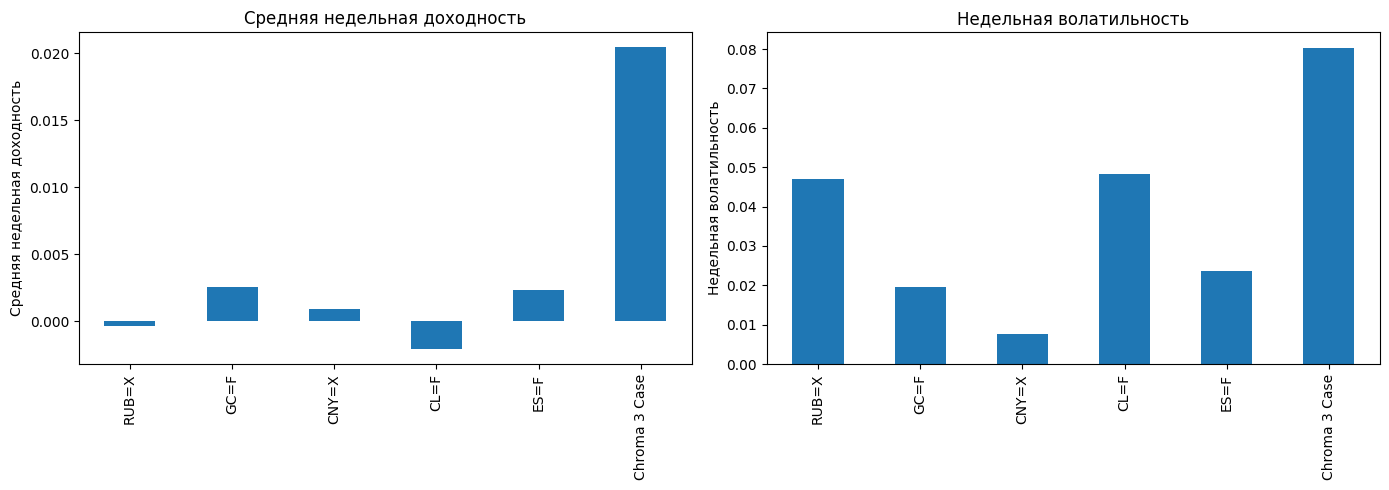

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

mean_weekly_returns.plot(kind='bar', ax=ax[0], title='Средняя недельная доходность')
ax[0].set_ylabel('Средняя недельная доходность')

weekly_volatility.plot(kind='bar', ax=ax[1], title='Недельная волатильность')
ax[1].set_ylabel('Недельная волатильность')

fig.tight_layout()


Chroma 3 Case и золото (GC=F) наиболее привлекательны с точки зрения средней доходности. Однако волатильность стоимости кейсов превышает золото примерно в 4 раза. Чтобы соотнести возможную прибыль с рисками, используем коэффициент Шарпа и Сортино. Коэффициент Шарпа используется для оценки, насколько доходность инвестиций компенсирует риск.

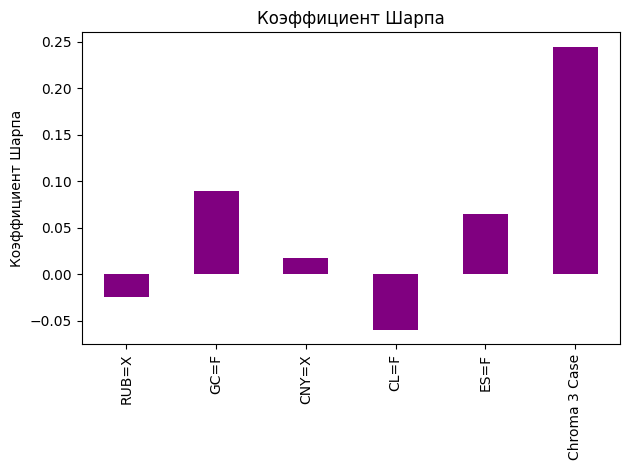

In [ ]:
sharpe_ratio.plot(kind='bar', title='Коэффициент Шарпа', color='purple')
plt.ylabel('Коэффициент Шарпа')
plt.tight_layout()


Chroma 3 Case имеет наибольший коэффициент Шарпа и значительно превосходит остальные активы, подтверждая свою высокую эффективность скорректированную на риск.

Также сравним коэффициенты Сортино - этот показатель лучше учитывает финансовые цели, так как фокусируется на потенциальных убытках, а не на общей волатильности.

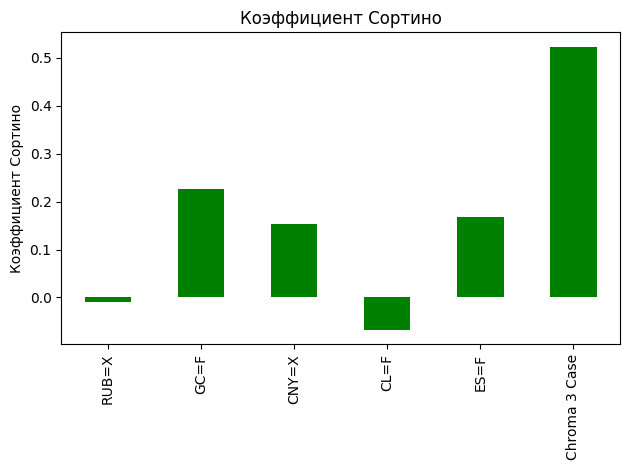

In [ ]:
sortino_ratio.plot(kind='bar', title='Коэффициент Сортино', color='green')
plt.ylabel('Коэффициент Сортино')
plt.tight_layout()


Chroma 3 Case снова имеет наибольший коэффициент, что означает лучший показатель эффективности скорректированной на риск потенциальных убытков.

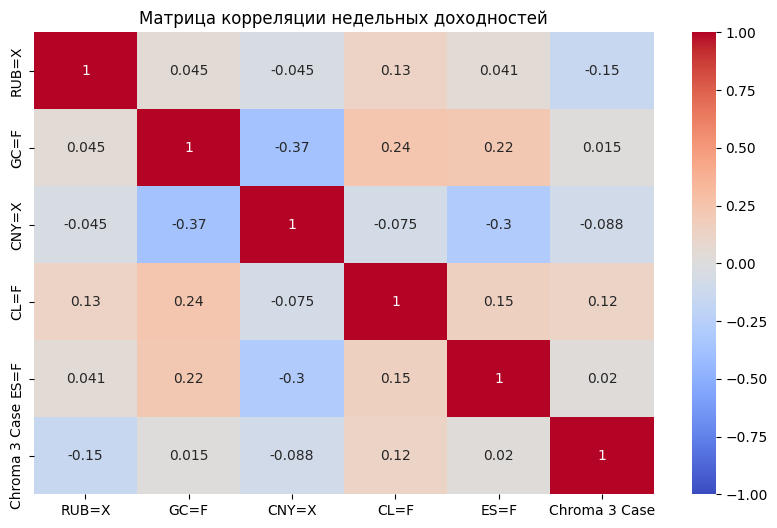

In [ ]:
plt.figure(figsize=(10, 6))
sns.heatmap(weekly_correlation, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Матрица корреляции недельных доходностей')
plt.show()


В случае выбора нескольких активов для инвестиций рекомендуется брать низкозависимые друг от друга позиции, чтобы диверсифицировать риск. Для анализа этого используем матрицу корреляции:

1. Влияние нефти на рубль:
   - Умеренная положительная корреляция между курсом рубля (RUB=X) и ценой нефти (CL=F) (0.128731) указывает на то, что рост цен на нефть может способствовать укреплению рубля.

2. Противоположное движение юаня и золота:
   - Умеренная отрицательная корреляция между курсом китайского юаня (CNY=X) и ценой на золото (GC=F) (-0.370523) означает, что рост юаня может сопровождаться снижением цен на золото и наоборот.

3. Нефть и золото:
   - Умеренная положительная корреляция между нефтью (CL=F) и золотом (GC=F) (0.237911) указывает на совместное движение этих двух товаров.

4. Связь между нефтью и американским фондовым рынком:
   - Умеренная положительная корреляция между нефтью (CL=F) и фьючерсами на S&P 500 (ES=F) (0.148733). Это говорит о том, что ралли на нефтяном рынке может иногда совпадать с ралли на американском рынке акций.

5. Обратная связь юаня и американского фондового рынка:
   - Умеренная отрицательная корреляция между юанем (CNY=X) и фьючерсами на S&P 500 (ES=F) (-0.295404) показывает, что, когда американский фондовый рынок растет, юань может ослабевать, и наоборот.

6. Chroma 3 Case и рубль:
   - Умеренная отрицательная корреляция между Chroma 3 Case и рублем (RUB=X) (-0.149691). Этот показатель может быть случайным, однако интересно отметить, что существует некоторая степень обратного движения между ними.
